# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [146]:
import os
import pickle
import numpy as np
import tensorflow as tf
import cv2

# Select computing device[CPU/GPU] for TensorFlow
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]='1'

#from tensorflow.python.client import device_lib
#print (device_lib.list_local_devices())

# Load pickled data
training_file     = "./dataset/train.p"
training_aug_file = "./dataset/train_aug.p"
validation_file   = "./dataset/valid.p"
testing_file      = "./dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(training_aug_file, mode='rb') as f:
    train_aug = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_train_aug, y_train_aug = train_aug['features'], train_aug['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [147]:
# Number of training examples
n_train = X_train.shape[0]

# Number of augmented training examples
n_train_aug = X_train_aug.shape[0]

# Number of validation examples
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
img_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of augmented training examples =", n_train_aug)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of augmented training examples = 36476
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

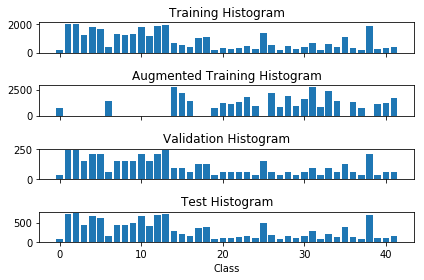

In [148]:
### Data exploration visualization code goes here.
### Histogram of original data.

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
hist, bins = np.histogram(y_train, bins = range(n_classes))
ax1.bar(bins[:-1], hist)
ax1.set_title('Training Histogram')
hist, bins = np.histogram(y_train_aug, bins = range(n_classes))
ax2.bar(bins[:-1], hist)
ax2.set_title('Augmented Training Histogram')
hist, bins = np.histogram(y_valid, bins = range(n_classes))
ax3.bar(bins[:-1], hist)
ax3.set_title('Validation Histogram')
hist, bins = np.histogram(y_test, bins = range(n_classes))
ax4.bar(bins[:-1], hist)
ax4.set_title('Test Histogram')
plt.xlabel("Class")
plt.tight_layout()
plt.show()


In [117]:
### Augment the training data by translating, scaling, rotating, and brightning
def translate_img(img):
    # Randomly translate image by [-2, 2] pixels in x and y directions
    # Values taken from Sermanet paper
    rows,cols,_ = img.shape 
    tx,ty = np.random.randint(-2,2,2)
    M = np.float32([[1,0,tx],[0,1,ty]])
    img_out = cv2.warpAffine(img,M,(cols,rows))
    return img_out

def rotate_img(img):
    # Randomly rotate image by [-15, 15] degrees around the center of the image
    # Values taken from Sermanet paper
    rows,cols,_ = img.shape
    drot = np.random.randint(-15,15,1)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),drot,1)
    img_out = cv2.warpAffine(img,M,(cols,rows))
    return img_out

def scale_img(img):
    # Randomly scale image by a factor of [0.9, 1.1] 
    # Values taken from Sermanet paper
    rows,cols,_ = img.shape
    dzoom = (0.2)*np.random.rand() + 0.9
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,dzoom)
    img_out = cv2.warpAffine(img,M,(cols,rows))
    return img_out

def brighten_img(img):
    img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_out[:,:,2] = img_out[:,:,2]+0.3*np.random.uniform()
    img_out = cv2.cvtColor(img_out, cv2.COLOR_HSV2RGB)
    return img_out

In [12]:
def augment_data(X,y):
    X_extend = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extend = np.empty([0], dtype = y.dtype)
    # Do not augment classes which have training examples aobe 2.5% of total number. 
    # Approximate way to balance dataset
    ignore_class = [1,2,3,4,5,7,8,9,10,11,12,13,17,18,25,35,38]
    
    for i in range(len(X)):
        if y[i] not in ignore_class:
            X_extend = np.append(X_extend, [translate_img(X[i])], axis=0)
            y_extend = np.append(y_extend, y[i])
            X_extend = np.append(X_extend, [rotate_img(X[i])], axis=0)
            y_extend = np.append(y_extend, y[i])
            X_extend = np.append(X_extend, [scale_img(X[i])], axis=0)
            y_extend = np.append(y_extend, y[i])
            X_extend = np.append(X_extend, [brighten_img(X[i])], axis=0)
            y_extend = np.append(y_extend, y[i])
        if(i%1000 == 0):
            print(i)
    return X_extend, y_extend                    

X_train_aug, y_train_aug = augment_data(X_train,y_train)
train_aug = {'features': X_train_aug,
             'labels': y_train_aug}
pickle.dump(train_aug, open( "./dataset/train_aug.p", "wb"))

### Pre-process the Data Set (normalization, grayscale, etc.)

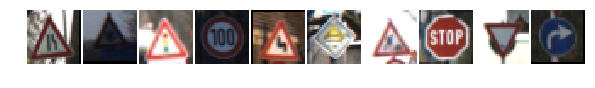

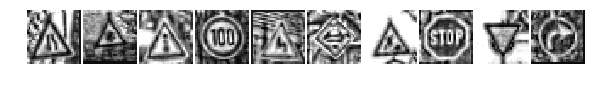

In [149]:
### Preprocess the data here. It is required to normalize the data.
def process_data(X, display = 'off'):
    
    img_idx = np.random.randint(0, len(X), 10)
        
    if display == 'on':
        fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
        #fig.suptitle("Original Images")
        fig.subplots_adjust(hspace=.1, wspace=.05)
        ax = ax.ravel()
        for i in range(10):
            ax[i].imshow(X[img_idx[i]])
            ax[i].axis('off')
                
    X_gray = np.zeros([X.shape[0], X.shape[1],X.shape[2]],dtype = X.dtype)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    
    for i in range(len(X)):
        # Convert to YUV colourspace
        #X[i] =  cv2.cvtColor(X[i], cv2.COLOR_RGB2YUV)
        # Convert to grayscale
        X_gray[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        # Equalise the grayscale channel 
        X_gray[i] = clahe.apply(X_gray[i])
                
    if display == 'on':
        fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
        #fig.suptitle("Processed Images")
        fig.subplots_adjust(hspace=.1, wspace=.05)
        ax = ax.ravel()
        for i in range(10):
            ax[i].imshow(X_gray[img_idx[i]], cmap='gray')
            ax[i].axis('off')

    # Normalise pixels between [0,1]. DOES NOT WORK!
    #X_gray = (X_gray/255).astype(np.float32)  
    
    # Add single grayscale channel for input to classifier
    X_gray = X_gray.reshape(X_gray.shape + (1,))
    return X_gray

# Combine original and augmented training data into final dataset
X_train = np.append(X_train, X_train_aug, axis=0)
y_train = np.append(y_train, y_train_aug, axis=0)
# Process all data
X_train = process_data(X_train, display='on')
X_valid = process_data(X_valid)
X_test  = process_data(X_test)

In [112]:
def display_data(X_in, display_num, cmap='gray'):
    #X = np.empty([X_in.shape[0], X_in.shape[1], X_in.shape[2]], dtype=np.uint8)
    X = X_in[:,:,:,0]
    img_idx = np.random.randint(0, len(X), display_num)
    ncols = 10
    nrows = int(display_num/ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    #fig.suptitle("Original Images")
    fig.subplots_adjust(hspace=.01, wspace=.05)
    ax = ax.ravel()
    for i in range(display_num):
        ax[i].imshow(X[img_idx[i]], cmap=cmap)
        ax[i].axis('off')

#display_data(X_train, 20)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Model Architecture

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [61]:
### Define your architecture here.
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Network layer sizes
    conv1_depth = 6
    conv2_depth = 16
    fc1_size    = 400
    fc2_size    = 120
    _,_,_,channels = x.get_shape().as_list()
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, conv1_depth), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_depth))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_depth, conv2_depth), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_depth))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # Flatten. Input = 5x5x16. Output = 400.
    fc_inp = flatten(conv2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(int(fc_inp.shape[1]), fc1_size), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_size))
    fc1   = tf.matmul(fc_inp, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob = keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(fc1_size, fc2_size), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(fc2_size))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob = keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(fc2_size, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [150]:
### Define your architecture here.
from tensorflow.contrib.layers import flatten

def MultiLeNet(x, keep_prob):    
    _,_,_,channels = x.get_shape().as_list()
        
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.01
    conv1_depth = 6
    conv2_depth = 16
    conv3_depth = 400
    fc1_size    = 800
    
    with tf.variable_scope('conv1'):
        # Layer 1: Convolutional. Input = 32x32xchannels (RGB or grayscale). Output = 28x28x6.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, conv1_depth), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(conv1_depth))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        # Activation
        conv1 = tf.nn.relu(conv1)
        # Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Flatten. Output = 1176
        fc_inp1 = flatten(conv1)
    
    with tf.variable_scope('conv2'):
        # Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_depth, conv2_depth), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(conv2_depth))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        # Activation.
        conv2 = tf.nn.relu(conv2)
        # Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Flatten. Output = 400
        fc_inp2 = flatten(conv2)
    
    with tf.variable_scope('conv3'):
        # Layer 3: Convolutional. Output = 1x1x400.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv2_depth, conv3_depth), mean = mu, stddev = sigma))
        conv3_b = tf.Variable(tf.zeros(conv3_depth))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
        # Activation.
        conv3 = tf.nn.relu(conv3)
        # Flatten. Output = 400
        fc_inp3 = flatten(conv3)
        
    # Flatten. Output = 800.
    fc_inp = tf.concat([fc_inp2, fc_inp3],1)
    
    # Dropout
    fc_inp = tf.nn.dropout(fc_inp, keep_prob)
        
    with tf.variable_scope('fc'):
        # Layer 4: Fully Connected. Input = 800. Output = n_classes.
        fc_W  = tf.Variable(tf.truncated_normal(shape=(int(fc_inp.shape[1]), n_classes), mean = mu, stddev = sigma))
        fc_b  = tf.Variable(tf.zeros(n_classes))
        logits = tf.matmul(fc_inp, fc_W) + fc_b
            
    return logits

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Train, Validate and Test the Model

In [151]:
### Set up training operations.
from sklearn.utils import shuffle

EPOCHS = 15
BATCH_SIZE = 128
checkpoint_dir = "./model_checkpoint/"
model_name     = "TrafficSignClassifier"

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
# dropout probability for FC layers
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits = MultiLeNet(x, keep_prob)
#logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training = optimizer.minimize(loss)

In [152]:
### Calculate and report the accuracy on the training and validation set.

batch_prediction = tf.argmax(logits,1)
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(one_hot_y, 1))
batch_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(tf.trainable_variables())

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    y_pred = []
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, y_pred_batch = sess.run([batch_accuracy, batch_prediction], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        y_pred.extend(y_pred_batch)
    return total_accuracy / num_examples, y_pred

In [153]:
### Train ConvNet model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(os.path.dirname(checkpoint_dir))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, batch_loss = sess.run([training,loss], feed_dict={x: batch_x, y: batch_y, keep_prob:0.6})
        #if (i+1)%10 == 0:
        print("EPOCH {} ...".format(i+1))    
        validation_accuracy, y_pred_valid = evaluate(X_valid, y_valid)
        print("Training Loss = {:.3f}".format(batch_loss), "Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    saver.save(sess, checkpoint_dir+model_name)
    print("Model saved")

Training...

EPOCH 1 ...
Training Loss = 0.407 Validation Accuracy = 0.913

EPOCH 2 ...
Training Loss = 0.171 Validation Accuracy = 0.939

EPOCH 3 ...
Training Loss = 0.104 Validation Accuracy = 0.942

EPOCH 4 ...
Training Loss = 0.066 Validation Accuracy = 0.945

EPOCH 5 ...
Training Loss = 0.111 Validation Accuracy = 0.960

EPOCH 6 ...
Training Loss = 0.156 Validation Accuracy = 0.953

EPOCH 7 ...
Training Loss = 0.055 Validation Accuracy = 0.950

EPOCH 8 ...
Training Loss = 0.052 Validation Accuracy = 0.953

EPOCH 9 ...
Training Loss = 0.050 Validation Accuracy = 0.957

EPOCH 10 ...
Training Loss = 0.176 Validation Accuracy = 0.956

EPOCH 11 ...
Training Loss = 0.114 Validation Accuracy = 0.954

EPOCH 12 ...
Training Loss = 0.056 Validation Accuracy = 0.952

EPOCH 13 ...
Training Loss = 0.173 Validation Accuracy = 0.953

EPOCH 14 ...
Training Loss = 0.028 Validation Accuracy = 0.951

EPOCH 15 ...
Training Loss = 0.034 Validation Accuracy = 0.949

Model saved


Confusion matrix, without normalization


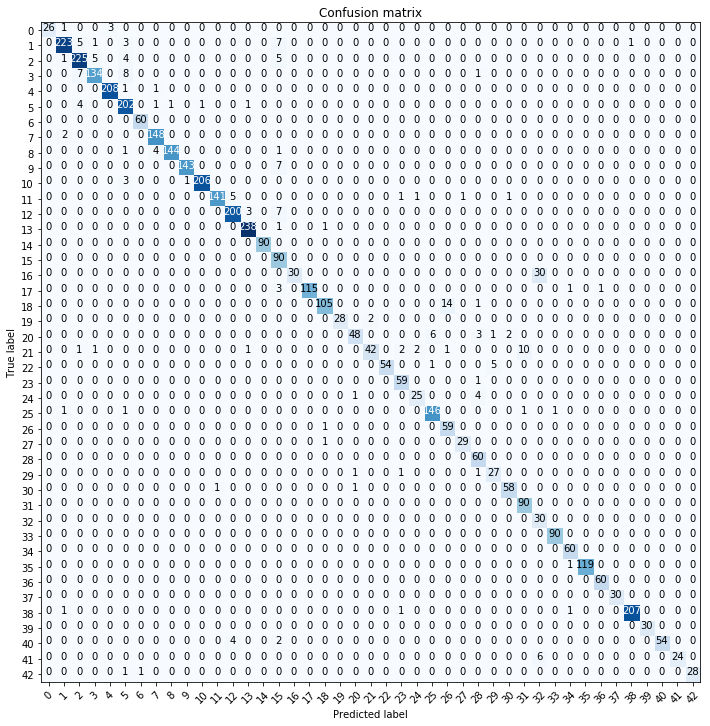

In [154]:
# Plot confusion matrix
# This function is taken from scikit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
labels = np.array([str(x) for x in range(n_classes)])
validation_matrix = confusion_matrix(y_valid, y_pred_valid)
plot_confusion_matrix(validation_matrix, labels)

Test Accuracy       = 0.927
Confusion matrix, without normalization


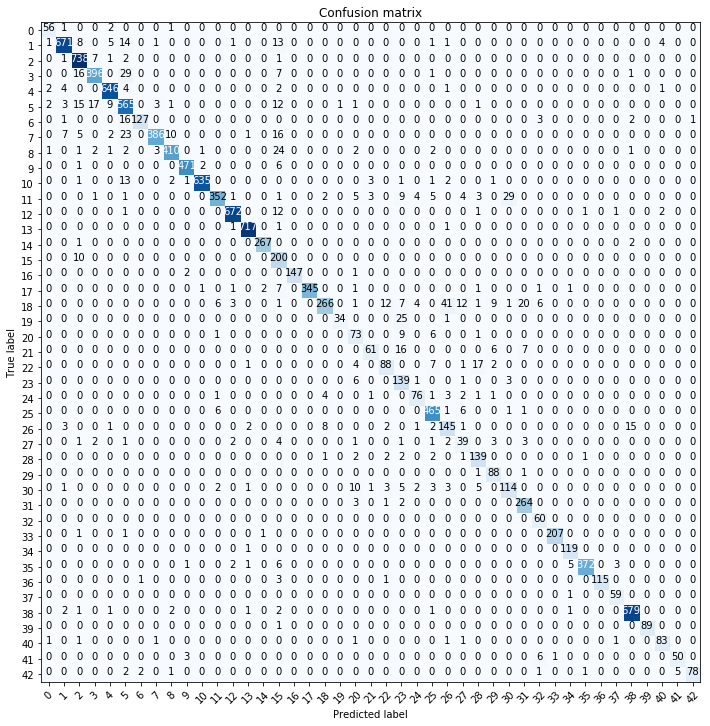

In [155]:
### Evaluate classification error on GTSRD test dataset from Udacity
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    test_accuracy, y_pred_test = evaluate(X_test, y_test)
    print("Test Accuracy       = {:.3f}".format(test_accuracy))
    test_matrix = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(test_matrix, labels)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

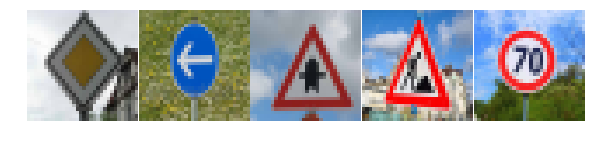

In [166]:
### Load the images and plot them here.
test_dir = "./dataset_test/five_images/"
n_new = 5
X_new = np.zeros([n_new, img_shape[0],img_shape[1],img_shape[2]],dtype=np.uint8)
y_new = [12,34,11,25,4] # Class IDs from GTSRB test date csv file for 5 images

fig, ax = plt.subplots(nrows=1, ncols=n_new, figsize=(10, 10))
fig.subplots_adjust(hspace=.1, wspace=.01)
ax = ax.ravel()
#fig.suptitle("Example Test Images")

img_names = os.listdir(test_dir)[:n_new]
i = 0;
for img_name in img_names:
    img = cv2.imread(test_dir+img_name)
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(img_shape[0],img_shape[1]),interpolation=cv2.INTER_AREA)
    X_new[i,:] = img
    ax[i].imshow(X_new[i])
    ax[i].axis('off')
    i += 1  

### Predict the Sign Type for Each Image

In [167]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    X_new = process_data(X_new)
    new_accuracy, y_pred_new = evaluate(X_new, y_new)
    print("Image Labels      =", y_new)
    print("Image Predictions =", y_pred_new) 
    print("Image Accuracy    = {:.3f}".format(new_accuracy))

Image Labels      = [12, 34, 11, 25, 4]
Image Predictions = [12, 34, 11, 25, 1]
Image Accuracy    = 0.800


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

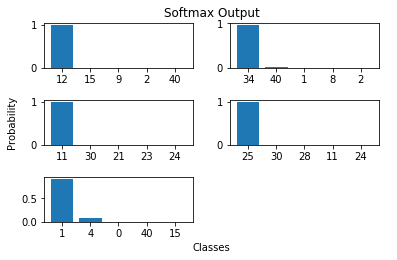

In [168]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    top_k = 5
    logits_test = sess.run(logits, feed_dict={x: X_new[0:n_new], keep_prob:1.0})
    softmax_test = tf.nn.softmax(logits_test)
    softmax_values, softmax_indices = sess.run(tf.nn.top_k(softmax_test, k=top_k)) 
    
    plot_cols = 2
    plot_rows = int(np.ceil(n_new/plot_cols))
    fig, ax = plt.subplots(nrows=plot_rows, ncols=plot_cols)
    i=0
    plt_x = np.arange(0, top_k)
       
    for i in range(0,plot_rows):
        for j in range(0,plot_cols):
            if j+plot_cols*i < n_new:
                ax[i,j].bar(plt_x, softmax_values[j+plot_cols*i])
                ax[i,j].set_xticks(plt_x)
                ax[i,j].set_xticklabels(softmax_indices[j+plot_cols*i])
            else:
                ax[i,j].axis('off')
    
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.xlabel("Classes")
    plt.ylabel("Probability")
    plt.title("Softmax Output")
    plt.tight_layout()
    plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


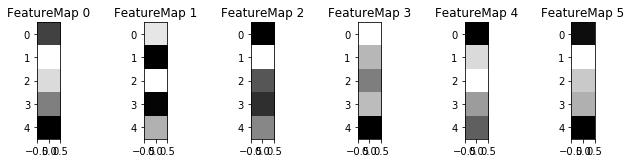

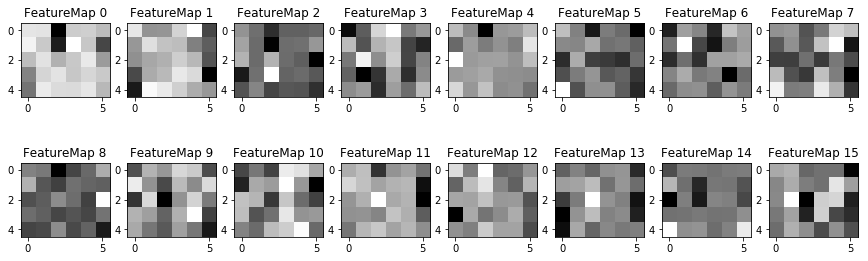

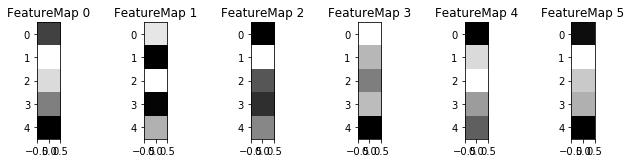

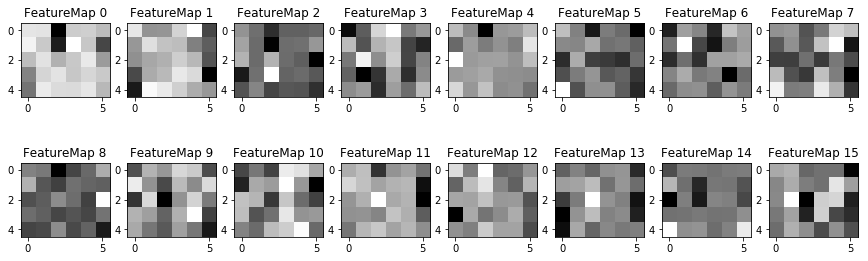

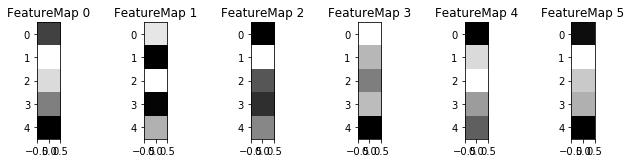

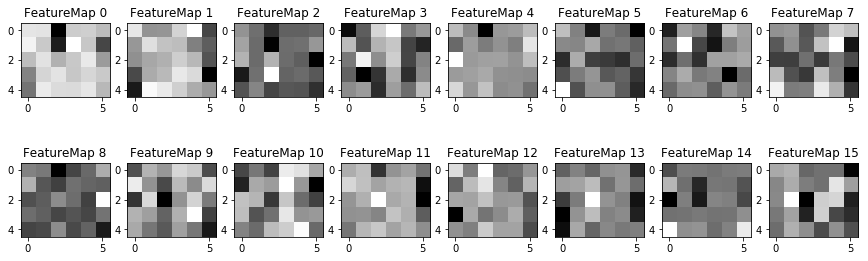

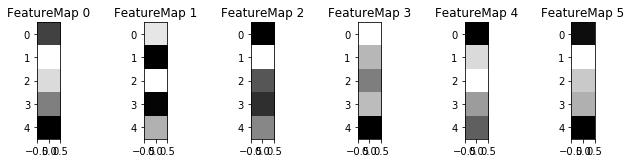

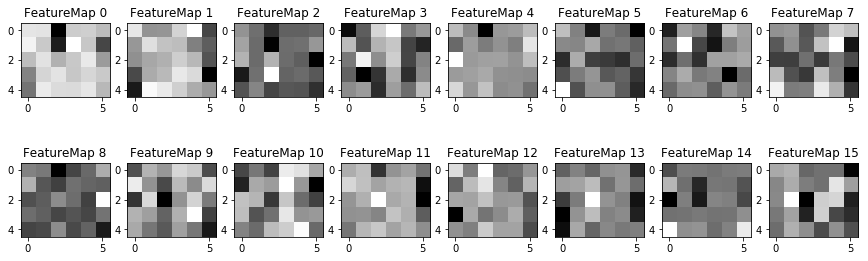

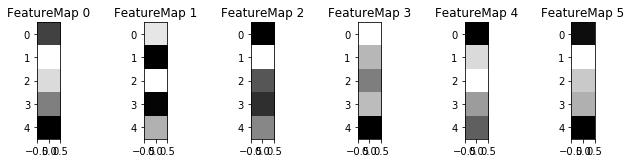

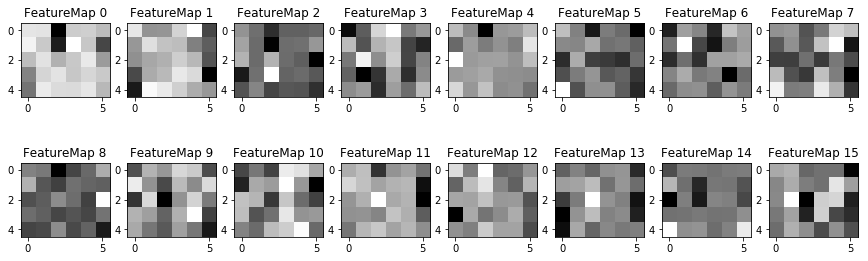

In [169]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    #process_data(image_input)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    graph = tf.get_default_graph()
    #for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        #print(v)
    conv1_layer = graph.get_tensor_by_name("conv1/Variable/read:0")   
    conv2_layer = graph.get_tensor_by_name("conv2/Variable/read:0")   
    for i in range(len(X_new)):
        outputFeatureMap([X_new[i]], conv1_layer)
        plt.show()
        outputFeatureMap([X_new[i]], conv2_layer)
        plt.show()
    #op1 = graph.get_operations()
    #[m.values() for m in op] 
    